<a href="https://colab.research.google.com/github/fellowship/Fridge-Food-Type/blob/master/FridgeFood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim 
import numpy as np 
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from collections import deque
import random 
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_on_gpu = True if torch.cuda.is_available() else False
train_on_gpu

False

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
del len

600 600 image_5.png


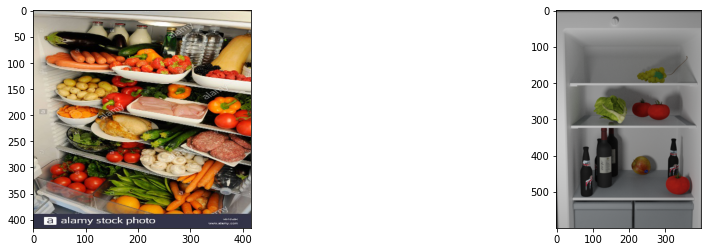

In [90]:
in_domain_imgs = '/content/gdrive/My Drive/in_domain/in_domain/'
synthetic_imgs = '/content/gdrive/My Drive/11_4_updated_images/11_4_updated_images/'
root_dir = '/content/gdrive/My Drive/'
os.chdir('/content/gdrive/My Drive/')

fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=2)
N_in_domain_imgs = [name for name in os.listdir(in_domain_imgs)]
N_synthetic_imgs = [name for name in os.listdir(synthetic_imgs) if '.png' in name]
N_in_domain_imgs = N_in_domain_imgs[0:600]

print(len(N_in_domain_imgs), len(N_synthetic_imgs), N_synthetic_imgs[5])
imgs = []
imgs.append(Image.open(in_domain_imgs + N_in_domain_imgs[5]))
imgs.append(Image.open(synthetic_imgs + N_synthetic_imgs[5]))
for ax, img in zip(axes.flatten(), imgs):
  i = ax.imshow(img)

plt.show()


In [91]:
class ImageDatasets(Dataset):
  def __init__(self, in_domain_imgs, synthetic_imgs, transform=None, device=None, indPath=None, synPath=None):
    self.indImgPath = indPath
    self.synImgPath = synPath
    self.transform = transform
    self.device = device 
    self.indImgs = in_domain_imgs
    self.synImgs = synthetic_imgs

  def __len__(self):
    if (len(self.indImgs) == len(self.synImgs)):
      return len(self.synImgs)

    else:
      return 0

  def __getitem__(self, index):

    targetImg = Image.open(self.indImgPath + self.indImgs[index])
    synImg = Image.open(self.synImgPath + self.synImgs[index])

    if self.transform:
      targetImg = self.transform(targetImg)
      synImg = self.transform(synImg)
    
    # feat_img = self.scale(feat_img)
    # target_img = self.scale(target_img)

    return targetImg.to(self.device), synImg.to(self.device)

  def scale(self, x, feature_range=(-1, 1)):
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [95]:
transform = transforms.Compose([
                                transforms.Resize((256, 256)),
                                transforms.RandomRotation(10), 
                                transforms.ToTensor()
                              ])

dataset = ImageDatasets(N_in_domain_imgs, N_synthetic_imgs, transform, device, in_domain_imgs, synthetic_imgs)
# Imgs_in_domain = datasets.ImageFolder(root_dir + 'in_domain/', transform=transform)
# Imgs_synthetic = datasets.ImageFolder(root_dir + '11_4_updated_images/', transform=transform)

dataset_size = len(dataset)
split = 0.9
indices = list(range(dataset_size))
train_indices = indices[ : int(dataset_size*split)]
# val_indices = indices[int(dataset_size*split) : dataset_size-int(dataset_size*0.1)]
test_indices = indices[int(dataset_size*split) :]

print(len(train_indices), len(test_indices))

train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)


540 60


In [94]:
t, s = dataset[5]
print(t.shape, s.shape, len(dataset))

torch.Size([3, 256, 256]) torch.Size([4, 256, 256]) 600


In [105]:
trainLoader = torch.utils.data.DataLoader(dataset, batch_size=8, sampler=train_sampler)
testLoader = torch.utils.data.DataLoader(dataset, batch_size=8, sampler=test_sampler)

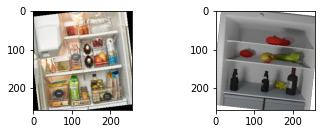

In [106]:
a = iter(trainLoader)
f, t = next(a)
feat = f[5].cpu()
tar = t[5].cpu()
i1 = torchvision.transforms.ToPILImage()(feat)
i2 = torchvision.transforms.ToPILImage()(tar)
fig = plt.figure()
a1 = fig.add_subplot(221)
a1.imshow(i1)
a2 = fig.add_subplot(222)
a2.imshow(i2)
plt.show()

In [26]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=False):
  layers = []
  conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(conv)
  if batch_norm:
    batch_norm_layer = nn.BatchNorm2d(out_channels)
    layers.append(batch_norm_layer)

  return nn.Sequential(*layers)

In [27]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=False):
  layers = []
  deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(deconv)
  if batch_norm:
    batchNorm = nn.BatchNorm2d(out_channels)
    layers.append(batchNorm)

  return nn.Sequential(*layers)

In [28]:
def in_conv(in_channel, out_channel, batchNorm, kernel_size=3, stride=1, padding=1):
  conv1 = conv(in_channel, out_channel, kernel_size, stride, padding, batchNorm)
  conv2 = conv(out_channel, out_channel, kernel_size, stride, padding, batchNorm)

  layers = [conv1, conv2]

  return nn.Sequential(*layers)

In [29]:
def down_samp_conv(in_channel, out_channel, batchNorm, kernel_size=3, stride=1, padding=1):
  pool_layer = nn.MaxPool2d(2, 2)
  conv_layers = in_conv(in_channel, out_channel, batchNorm)

  layers = [pool_layer, conv_layers]
  return nn.Sequential(*layers)

In [30]:
def up_samp_conv(in_channel, out_channel, batchNorm, kernel_size=4, stride=2, padding=1):
  deconv_layer = deconv(in_channel, out_channel, kernel_size, stride, padding, batchNorm)

  return nn.Sequential(deconv_layer)

In [31]:
class Generator(nn.Module):
  def __init__(self, conv_dims=32):
    super(Generator, self).__init__()
    self.seed = 42
    ## input 3x256x256
    self.in_layer = in_conv(3, conv_dims, True) ## 32x128x128 32x256x256

    self.down_samp_conv1 = down_samp_conv(conv_dims, conv_dims*2, True) ## 64x64x64  64x128x128
    self.down_samp_conv2 = down_samp_conv(conv_dims*2, conv_dims*4, True) ## 128x32x32 128x64x64
    self.down_samp_conv3 = down_samp_conv(conv_dims*4, conv_dims*8, True) ## 256x16x16 256x32x32
    self.down_samp_conv4 = down_samp_conv(conv_dims*8, conv_dims*16, True) ## 512x16x16

    self.up_samp_conv0 = up_samp_conv(conv_dims*16, conv_dims*8, True) ## 256x32x32
    self.up_concat_conv0 = in_conv(conv_dims*16, conv_dims*8, True) 
    self.up_samp_conv1 = up_samp_conv(conv_dims*8, conv_dims*4, True)  ## 128x64x64
    self.up_concat_conv1 = in_conv(conv_dims*8, conv_dims*4, True)
    self.up_samp_conv2 = up_samp_conv(conv_dims*4, conv_dims*2, True) ## 64x128x128
    self.up_concat_conv2 = in_conv(conv_dims*4, conv_dims*2, True)
    self.up_samp_conv3 = up_samp_conv(conv_dims*2, conv_dims, True) ## 32x256x256
    self.up_concat_conv3 = in_conv(conv_dims*2, conv_dims, True)

    self.out_layer = nn.Sequential(*[conv(conv_dims, 4, True),  
                                     conv(4, 4)])                   ## 4x256x256
    
    # in_conv(conv_dims, 4)

  def forward(self, x):
    ## Input size 3x256x256
    l1 = F.relu(self.in_layer(x)) ## 32x256x256
    d_l2 = F.relu(self.down_samp_conv1(l1)) ## 64x128x128
    d_l3 = F.relu(self.down_samp_conv2(d_l2)) ## 128x64x64
    d_l4 = F.relu(self.down_samp_conv3(d_l3)) ## 256x32x32
    d_l5 = F.relu(self.down_samp_conv4(d_l4)) ## 512x16x16

    up_l0 = F.relu(self.up_samp_conv0(d_l5)) ## 256x32x32
    up_l0_concat = torch.cat([up_l0, d_l4], dim=1) ## 512x32x32
    up_l0_concat = F.relu(self.up_concat_conv0(up_l0_concat)) ## 256x32x32

    up_l1 = F.relu(self.up_samp_conv1(d_l4)) ## 128x64x64
    up_l1_concat = torch.cat([up_l1, d_l3], dim=1) ## 256x32x32
    up_l1 = F.relu(self.up_concat_conv1(up_l1_concat))  ## 128x64x64

    up_l2 = F.relu(self.up_samp_conv2(up_l1)) ## 64x128x128
    up_l2_concat = torch.cat([up_l2, d_l2], dim=1) ## 128x128x128
    up_l2 = F.relu(self.up_concat_conv2(up_l2_concat))  ## 64x128x128

    up_l3 = F.relu(self.up_samp_conv3(up_l2)) ## 32x256x256
    up_l3_concat = torch.cat([up_l3, l1], dim=1) ## 64x256x256
    up_l3 = F.relu(self.up_concat_conv3(up_l3_concat))  ## 32x256x256

    out_layer = torch.tanh(self.out_layer(up_l3)) ## 4x256x236

    return out_layer


In [32]:
class Discriminator(nn.Module):
  def __init__(self, conv_dims=32):
    super(Discriminator, self).__init__()
    
    self.conv1 = conv(4, conv_dims)   ## 32x128x128
    self.conv2 = conv(conv_dims, conv_dims*2, batch_norm=True)  ## 64x64x64
    self.conv3 = conv(conv_dims*2, conv_dims*4, batch_norm=True)  ## 128x32x32
    self.conv4 = conv(conv_dims*4, conv_dims*8, batch_norm=True)  ## 256x16x16

    self.fc = nn.Linear(256*16*16, 1)

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = F.leaky_relu(self.conv2(x), 0.2)
    x = F.leaky_relu(self.conv3(x), 0.2)
    x = F.leaky_relu(self.conv4(x), 0.2)
    x = x.view(-1, 16*16*256)

    return self.fc(x)



In [33]:
G, D = Generator(), Discriminator()
G = G.to(device)
D = D.to(device)

In [34]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

  ## https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/pix2pix_model.py

In [35]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.99

g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])

In [36]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
      img = img.detach().cpu().numpy()
      img = np.transpose(img, (1, 2, 0))
      img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
      # print(min(img), max(img))
      ax.xaxis.set_visible(False)
      ax.yaxis.set_visible(False)
      im = ax.imshow(img.reshape((128,128,3)))
    
    plt.show()

In [49]:
import pickle as pkl 

n_epochs = 3000
samples = []
losses = []
print_every = 50
sample_size=8

In [50]:
def scale(x, feature_range=(-1, 1)):
  # scale from 0-1 to feature_range
  min, max = feature_range
  x = x * (max - min) + min
  return x

In [58]:
img = scale(img[0])
print(torch.min(img), torch.max(img))

tensor(-1.) tensor(1.)


In [70]:
!pip3 install barbar

In [116]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
      img = img.detach().cpu().numpy()
      img = np.transpose(img, (1, 2, 0))
      img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
      # print(min(img), max(img))
      ax.xaxis.set_visible(False)
      ax.yaxis.set_visible(False)
      im = ax.imshow(img.reshape((256,256,3)))
    
    plt.show()



In [117]:
def trainingLoop(trainLoader, valLoader, n_epochs):
  min_loss = 10000.0

  iter_train_imgs = iter(trainLoader)
  iter_test_imgs = iter(testLoader)

  train_loss_deque = deque(maxlen=10)
  batch_per_epochs_train = len(trainLoader)
  batch_per_epoch_test = len(testLoader)

  for epoch in range(n_epoch):
    if epoch % batch_per_epochs_train == 0:
      iter_train_imgs = iter(trainLoader)

    indImg, synImg = next(iter_train_imgs)
    indImg = scale(indImg)
    synImg = scale(synImg)

    ## Discriminator Loss 
    d_optimizer.zero_grad()
    if train_on_gpu:
      indImg = indImg.cuda()
      synImg = synImg.cuda()

    real_pred = D(indImg)
    r_loss = real_loss(real_pred, smooth=True)

    fake_img = G(synImg)
    fake_pred = D(fake_img)
    f_loss = fake_loss(fake_pred)

    d_loss = f_loss + r_loss 
    d_loss.backward()
    d_optimizer.step()

    ## Generator Loss 
    g_optimizer.zero_grad()

    fake_img = G(synImg)
    fake_pred = D(fake_img)
    g_loss = real_loss(fake_pred)

    g_loss.backward()
    g_optimizer.step()

    if batch_index % print_every == 0:
      losses.append((d_loss.item(), g_loss.item()))
      print(' Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch + 1, n_epochs, d_loss.item(), g_loss.item()))
      
      G.eval()
      with torch.no_grad():
        indImg_test, synImg_test = next(testLoader)
        indImg_test = scale(indImg_test)
        synImg_test = scale(synImg_test)

        if train_on_gpu:
          indImg_test = indImg_test.cuda()
          synImg_test = synImg_test.cuda()

        fakeImg = G(synImg_test)
        samples.append(fakeImg)
        _ = view_samples(-1, samples)

      G.train()





In [118]:
trainingLoop(trainLoader, testLoader, n_epochs)

NameError: ignored